<img src="images/hotel.jpg" alt="example" style="width:1500px; height:500px;">

# Eco Oasis Suites: Investigating Hotel Reservation Cancellations
* Author: Angela Loyola
* Student pace: Self-Paced
* Instructor name: Mark Barbour

<i> For the purpose of this project, I will be acting as a Data Scientist working for Eco-Oasis Suites. </i>

## Overview & Business Problem

Eco Oasis Suites is a new chain of fully sustainable and eco-friendly hotels. With features such as green rooftops and solar panels, the chain has established itself as a pioneer in the industry, attracting environmentally conscious travelers. However, the business is currently grappling with an increasing number of cancelled reservations, posing a significant challenge to its overall profitability.

The last-minute nature of these cancellations leasves the hotels with minimal time to fill the vacant rooms before the scheduled arrival dates. This not only leads to missed revenue opportunities but also disrupts the operational efficiency of the hotel. The need to address this problem has prompted the chain to seek a proactive solution – a tool that can help identify reservations at risk of cancellation well in advance in order to allow for intervention. 

Once the tool identifies reservations at risk of cancellation, Eco Oasis Suites can launch targeted interventions to encourage guests to retain their bookings. Possible interventions may include offering meal vouchers, exclusive promotions, room upgrades, or personalized incentives aligned with the brand's sustainability values. The goal is not only to minimize cancellations but also to enhance guest satisfaction and loyalty.

## Data Understanding and Exploration

In [1]:
### Importing all packages and libaries 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly.io import to_image
init_notebook_mode(connected=True)
import plotly.express as px

1. Load Data

<i> Overview: </i> The data comes from one dataframe with 32 variables. The target varaible is "is_canceled" which is a binary indicator with 1 incdicating a canceled reservation and 0 meaning otherwise. 

<i>Data Types: </i>Columns such as Agent and Company are stored as numerical features, but since they are ID numbers, they shouldn't be treated as numercical values in the model. I will exclude them from the model. 

<i>Distribution of the Target:</i> The distribution plot for the target variable shows a class imbalance with 44k canceled reservations versus 75k non-canceled reservations. This suggests that SMOTE could be tested to improve recall on the model. 

<i>Categorical Values:</i> By looking at the value counts for the categorical values, I identified which would be useful to test in the model. Columns that had months or dates (not stored as date type objects) will be excluded. 

<i>Numerical Values:</i> There are no significant correlations between variables that would indicate any are accounting for the same variation. The highest correlation to "is_cancelled" is "lead_time" with a .29. It will be interesting to see if this is an important variable in the models using Feature Importance later on. 

In [3]:
df = pd.read_csv('data/hotel_booking_data_cleaned.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
fig = px.histogram(df, x='is_canceled', title='Distribution of Canceled Reservations', 
                   labels={'is_canceled': 'Cancellation Status'},
                   nbins=2,  
                   width=900, height=800)

# Get counts for each category
counts = df['is_canceled'].value_counts()

# Add data labels with formatted counts
fig.update_traces(text=counts.apply(lambda x: f'{x:,.0f}'),
                  textposition='outside',  # Display text outside the bars
                  )

# Adjust the bargap between bars
fig.update_layout(bargap=0.2)

fig.show()

### Categorical Variables

After looking at the value counts and the distribution of all the categorical variables in the model, I identified the following variables would make good candidates for creating dummies and testing in the model: 
1. Hotel
2. Meal 
3. Market_segment 
4. Distribution_channel 
5. Reserved Room Type
6. Deposit Type

These were chosen because they provided useful information for the model and were stored as the correct object. For example, there is not much information to be extracted from the arrival_date_month and I don't want the model to weight this variable. Additionally, "reservation_status_date" is a date but was stored as object by accident. It won't be necessary to address this as it will be better to exclude this date from the analysis as well. 

In [6]:
categorical_columns = df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    print(f"Value counts for {column}:\n{df[column].value_counts()}\n")

Value counts for hotel:
City Hotel      79330
Resort Hotel    40060
Name: hotel, dtype: int64

Value counts for arrival_date_month:
August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

Value counts for meal:
BB           92310
HB           14463
SC           10650
Undefined     1169
FB             798
Name: meal, dtype: int64

Value counts for country:
PRT    48590
GBR    12129
FRA    10415
ESP     8568
DEU     7287
       ...  
DJI        1
BWA        1
HND        1
VGB        1
NAM        1
Name: country, Length: 177, dtype: int64

Value counts for market_segment:
Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype:

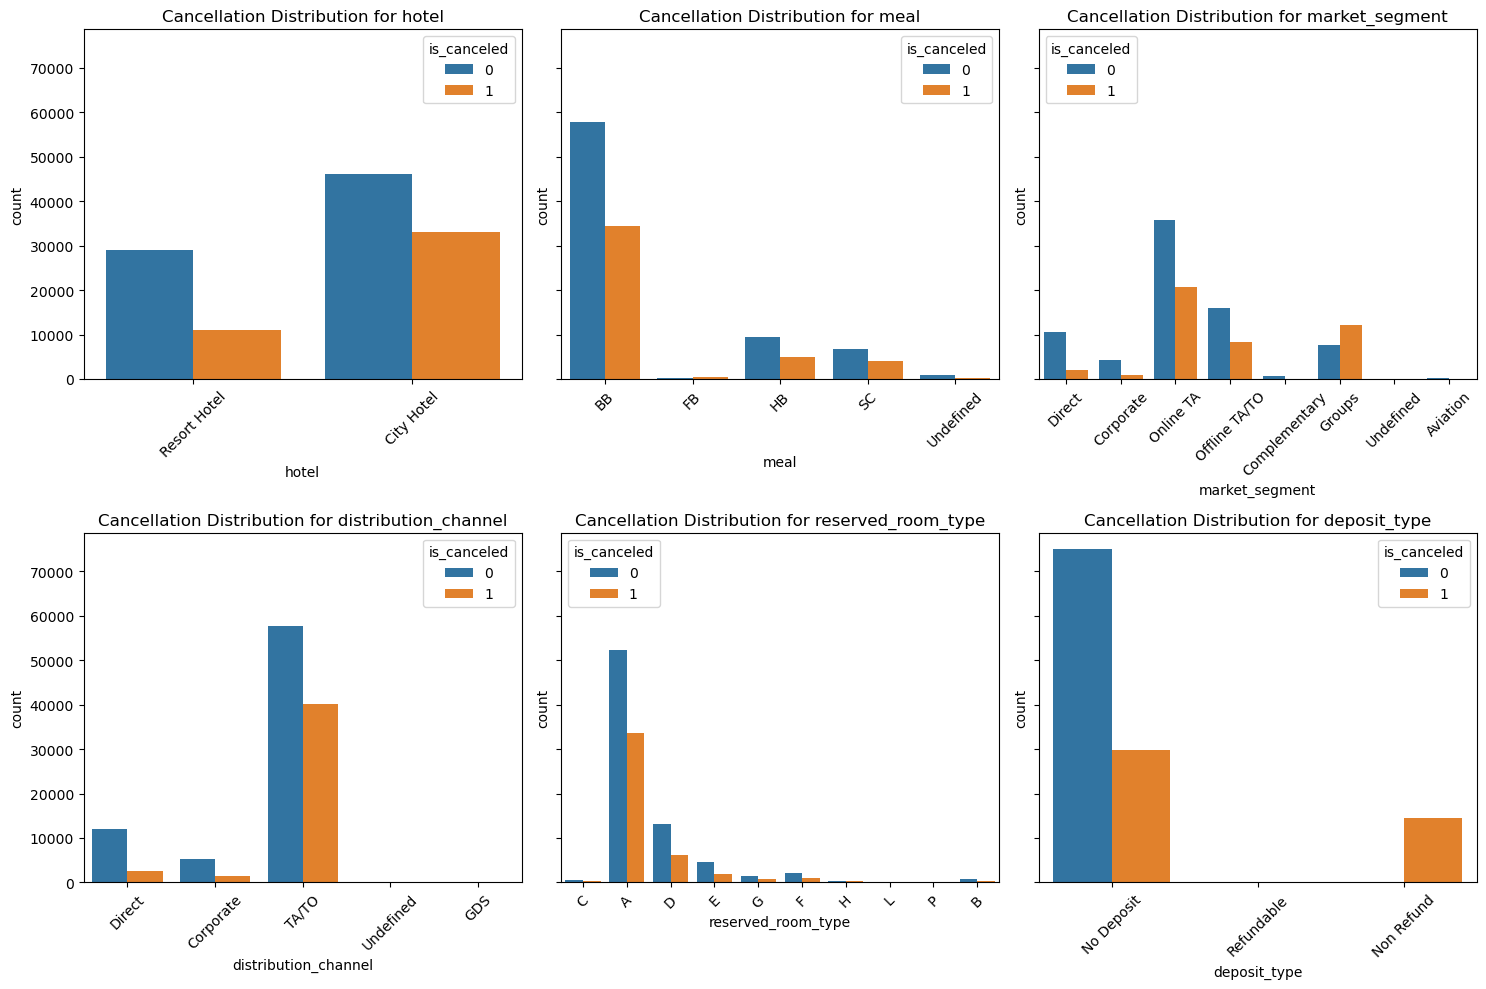

In [7]:
x_values_list = ['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10), sharey=True)
axes = axes.flatten()

# Iterate through the list above and create subplots
for i, x_value in enumerate(x_values_list):
    sns.countplot(x=x_value, hue='is_canceled', data=df, ax=axes[i])
    axes[i].set_title(f'Cancellation Distribution for {x_value}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Numerical Values 

In this section, I dropped columns that were numerical values but should not be treated as such by the model. The variables that remained were: 
1. Lead Time
2. Stays in weekend nights
3. Distribution of Adults
4. Distribution of children
5. Distribution of Babies
6. Previous Cancellations
7. Distribution of Booking Changes
8. Total of Special Requests

After plotting distribution, I noticed that lead time was the only variable that had a wide distribution. 

In [8]:
##Drop columns that should not be treated as numerical values 
df_numerical_values = df.select_dtypes(include=["int64","float64"]).drop(columns = ['arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'company', 'adr', 'agent'])

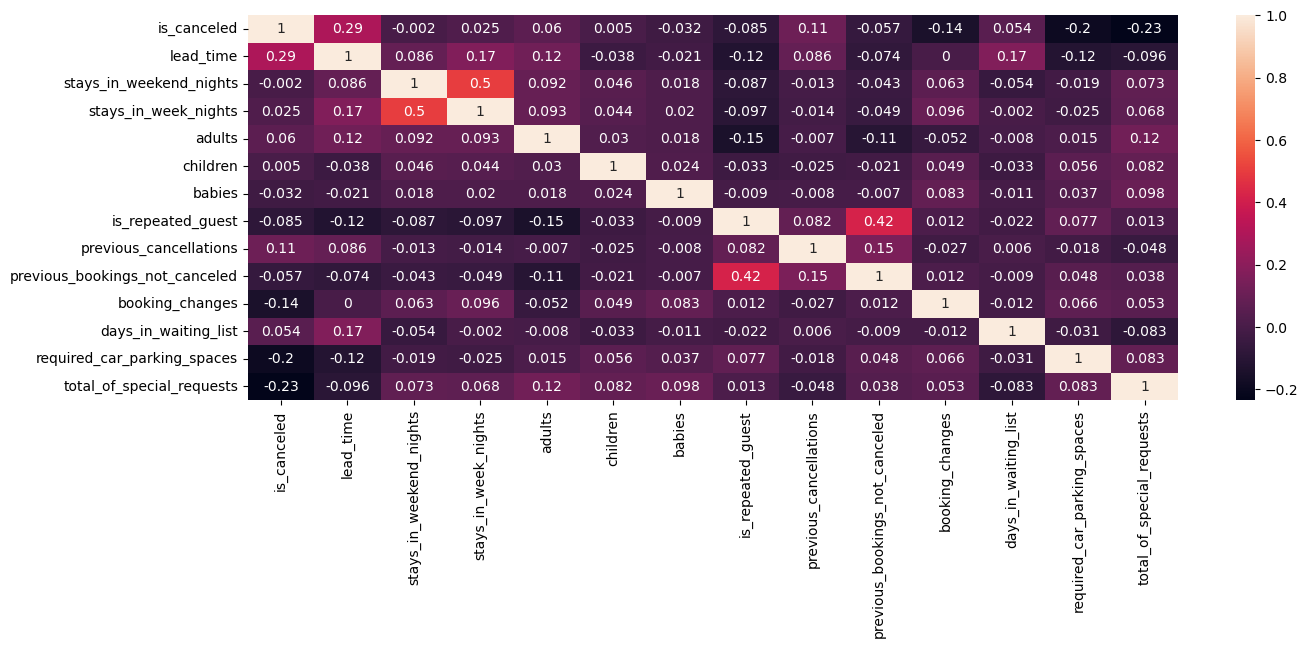

In [9]:
##Create correlation matrix 
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_numerical_values.corr().round(decimals=3),annot=True);

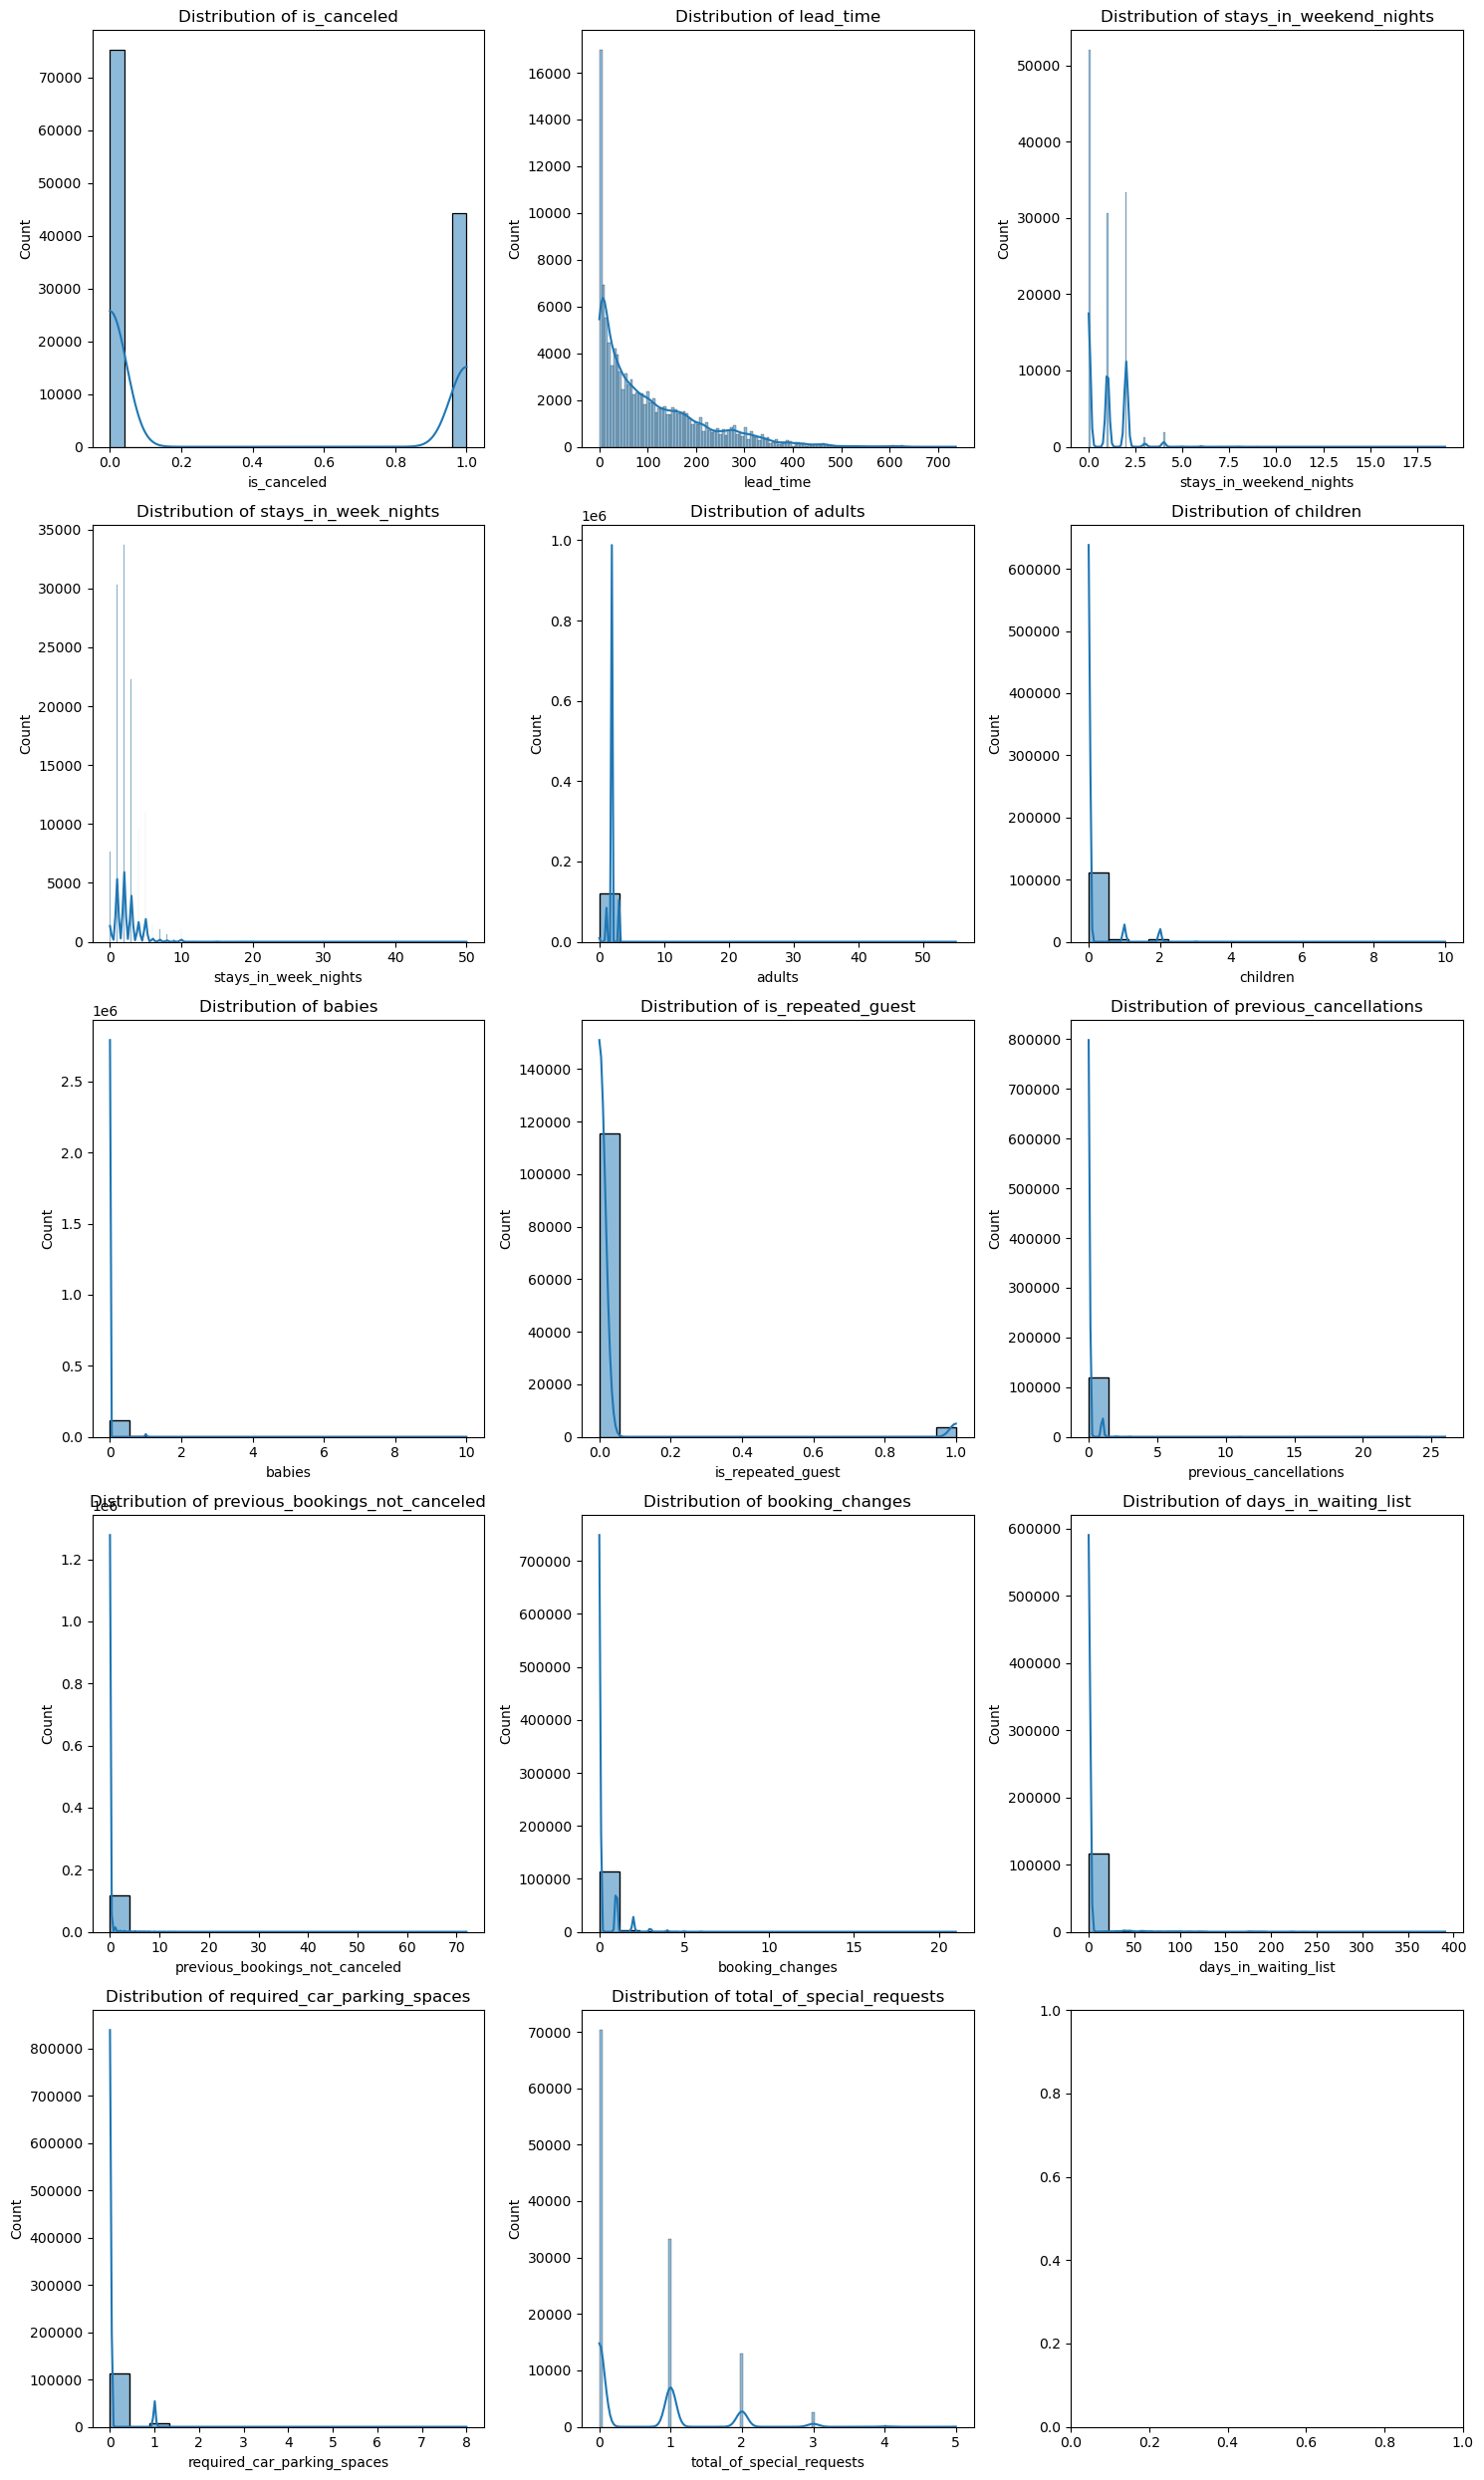

In [10]:
# Set up subplots
fig, axes = plt.subplots(nrows=len(df_numerical_values.columns)//3 + 1, ncols=3, figsize=(15, 5 * (len(df_numerical_values.columns)//3 + 1)))
axes = axes.flatten()

# Iterate through numerical columns and create subplots
for i, col in enumerate(df_numerical_values):
    sns.histplot(df_numerical_values[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.show()

## Data Processing

In this section, I create the dummy variables for the selected categorical variables above. I also handle missing values and wrong datatype in the "childrens" column. 

I then subset the full dataframe to the selected categorical and numerical columns to include in the models by dropping one categorical variable per group to avoid noise and co-linearity errors. 

In [11]:
# Use pd.get_dummies to create dummy variables
df_dummies = pd.get_dummies(df, columns=['hotel', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type'])

# Display the resulting DataFrame
df_dummies

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable
0,0,342,2015,July,27,1,0,0,2,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0,737,2015,July,27,1,0,0,2,0.0,...,0,0,0,0,0,0,0,1,0,0
2,0,7,2015,July,27,1,0,1,1,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0,13,2015,July,27,1,0,1,1,0.0,...,0,0,0,0,0,0,0,1,0,0
4,0,14,2015,July,27,1,0,2,2,0.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,August,35,30,2,5,2,0.0,...,0,0,0,0,0,0,0,1,0,0
119386,0,102,2017,August,35,31,2,5,3,0.0,...,0,1,0,0,0,0,0,1,0,0
119387,0,34,2017,August,35,31,2,5,2,0.0,...,1,0,0,0,0,0,0,1,0,0
119388,0,109,2017,August,35,31,2,5,2,0.0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
selected_columns = ['hotel_City Hotel',
       'meal_BB', 'meal_FB', 'meal_HB', 'meal_SC',
       'market_segment_Aviation', 
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline TA/TO',
       'market_segment_Online TA',
       'distribution_channel_Corporate', 'distribution_channel_Direct',
       'distribution_channel_GDS', 
       'reserved_room_type_A',
       'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D',
       'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G',
       'reserved_room_type_H', 'reserved_room_type_L', 
       'deposit_type_No Deposit', 
       'deposit_type_Refundable','stays_in_weekend_nights', 'adults', 'children',
                     'babies', 'is_repeated_guest', 'previous_cancellations',
                     'booking_changes', 'total_of_special_requests', 'is_canceled']

subset_df = df_dummies[selected_columns]

subset_df

,hotel_City Hotel,meal_BB,meal_FB,meal_HB,meal_SC,market_segment_Aviation,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,...,deposit_type_Refundable,stays_in_weekend_nights,adults,children,babies,is_repeated_guest,previous_cancellations,booking_changes,total_of_special_requests,is_canceled
0,0,1,0,0,0,0,0,1,0,0,...,0,0,2,0.0,0,0,0,3,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,2,0.0,0,0,0,4,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,1,0.0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,1,0.0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,2,0.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,1,1,0,0,0,0,0,0,0,1,...,0,2,2,0.0,0,0,0,0,0,0
119386,1,1,0,0,0,0,0,0,0,0,...,0,2,3,0.0,0,0,0,0,2,0
119387,1,1,0,0,0,0,0,0,0,0,...,0,2,2,0.0,0,0,0,0,4,0
119388,1,1,0,0,0,0,0,0,0,0,...,0,2,2,0.0,0,0,0,0,0,0


In [14]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel_City Hotel                119390 non-null  uint8  
 1   meal_BB                         119390 non-null  uint8  
 2   meal_FB                         119390 non-null  uint8  
 3   meal_HB                         119390 non-null  uint8  
 4   meal_SC                         119390 non-null  uint8  
 5   market_segment_Aviation         119390 non-null  uint8  
 6   market_segment_Corporate        119390 non-null  uint8  
 7   market_segment_Direct           119390 non-null  uint8  
 8   market_segment_Groups           119390 non-null  uint8  
 9   market_segment_Offline TA/TO    119390 non-null  uint8  
 10  market_segment_Online TA        119390 non-null  uint8  
 11  distribution_channel_Corporate  119390 non-null  uint8  
 12  distribution_cha

In [15]:
subset_df =subset_df.dropna()

In [16]:
subset_df['children'] = subset_df['children'].astype(int)

C:\Users\AngelaLOYOLA\AppData\Local\Temp\ipykernel_16484\2866082383.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Baseline Model: Regular DecisionTreeClassifier

In this section, I will build a regular decsion tress to establish a baseline to measure performance of the classifier in further iterations. 

This section performs and train, test, split with a test size of 25% and using a random state to ensure the model results are reproducible. 

<b> Results: </b> 

The most important feature in the classifer is Deposit Type. 

Precision: For class 0, it's 0.80, meaning that when the model predicts a sample belongs to class 0, it is correct 80% of the time. For class 1, it's 0.79, indicating 79% accuracy in predicting class 1 instances.

Recall: For class 0, it's 0.90, suggesting that the model correctly identifies 90% of all actual class 0 instances. For class 1, it's 0.61, meaning that the model identifies 61% of all actual class 1 instances.

The model is performing better at predicitng the Class 0 (non-canceled reservations). It is likely this is due to the class imbalance in the dataset leading to the classifier favoring Class 0. 

<b> Next Steps: </b> 

I will run a Random Forest model after using SMOTE to generate synthetic data for Class 1. 

In [17]:
subset = subset_df.drop(columns = 'is_canceled')
target = subset_df['is_canceled']

In [18]:
data_train, data_test, target_train, target_test = train_test_split(subset, target, test_size = .25, random_state = 123)

In [19]:
tree_clf = DecisionTreeClassifier(criterion = 'gini')
tree_clf.fit(data_train, target_train)

DecisionTreeClassifier()

In [20]:
def get_top_features(model, data_train, top_n=10):
    feature_importances = model.feature_importances_
    sorted_indices = np.argsort(feature_importances)[::-1]
    
    top_feature_indices = sorted_indices[:top_n]
    top_features = data_train.columns.values[top_feature_indices]
    top_importances = feature_importances[top_feature_indices]

    return list(zip(top_features, top_importances))

# Example usage:
top_features = get_top_features(tree_clf, data_train)
print("Top 10 Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 Features and Importances:
deposit_type_No Deposit: 0.49296342190291476
total_of_special_requests: 0.10319519752501606
market_segment_Online TA: 0.07932470383516657
previous_cancellations: 0.06804150493789297
stays_in_weekend_nights: 0.03889752378089147
adults: 0.03279521562994465
booking_changes: 0.032075926570979504
distribution_channel_Corporate: 0.02095792189487317
hotel_City Hotel: 0.01605936288194618
children: 0.014116462562571066


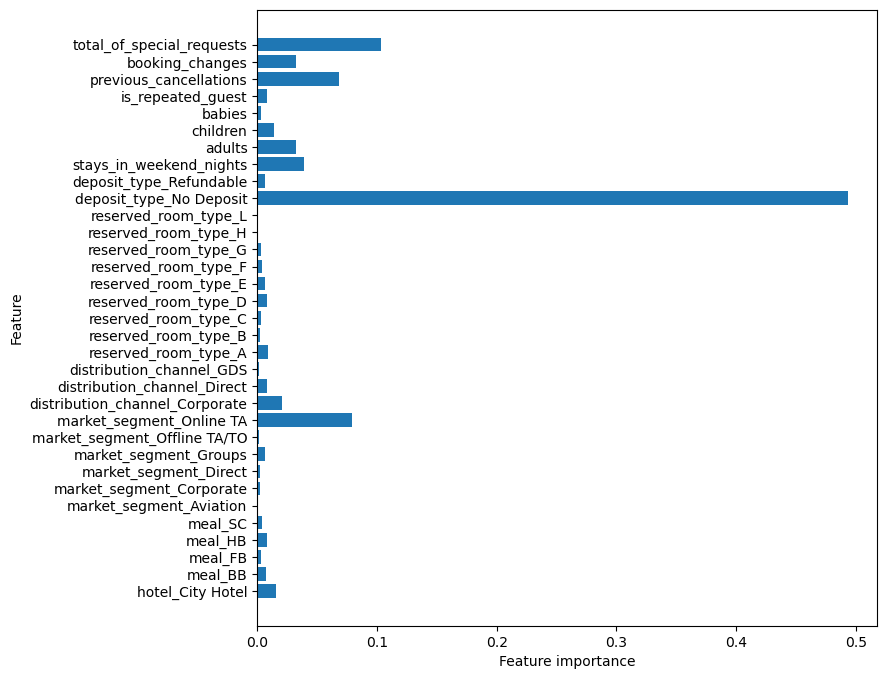

In [21]:
def plot_feature_importances(model):
    n_features = data_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), data_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(tree_clf)

In [22]:
# Test set predictions
pred = tree_clf.predict(data_test)

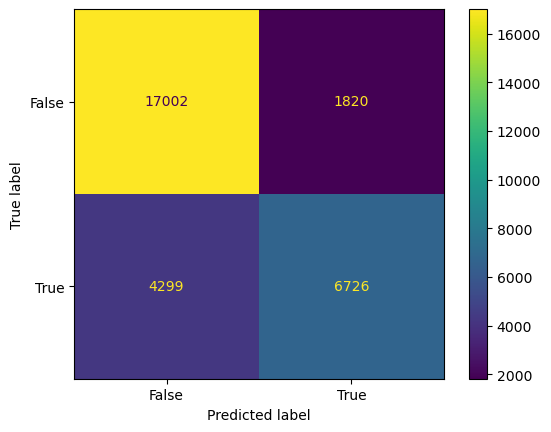

In [23]:
##Favor for Prediciting Class 0 so I think I need to implement Smote before calling random forest
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(target_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [24]:
print(classification_report(target_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85     18822
           1       0.79      0.61      0.69     11025

    accuracy                           0.79     29847
   macro avg       0.79      0.76      0.77     29847
weighted avg       0.79      0.79      0.79     29847



## Random Forest Model

The next model uses Random Forests to aggregate multiple decision trees and mitigate the risk of individual trees making biased predictions. In this version of the model, SMOTE is applied to balance out the class distribution. 

<b> Results: </b> 

The most important feature in this classifer is still Deposit Type. 

Precision: For class 0, it's 0.82, meaning that when the model predicts a sample belongs to class 0, it is correct 82% of the time. For class 1, it's 0.72, indicating 72% accuracy in predicting class 1 instances. For Class 0 the precision went up 2 percentage points, while it went down 7 percentage points for Class 1. 

Recall: For class 0, it's 0.85, suggesting that the model correctly identifies 85% of all actual class 0 instances. For class 1, it's 0.68, meaning that the model identifies 68% of all actual class 1 instances.

The model is still performing better at predicting the Class 0 (non-canceled reservations), yet the recall for Class 1 has improved 7 percentage points.

<b> Next Steps: </b> 

My next step is running GridSearch for the Random Forest Classifer to find the best hyperparameters for the model. 

In [25]:
rf_clf = RandomForestClassifier()

In [26]:
smote = SMOTE(random_state=42)
data_train_resampled, target_train_resampled = smote.fit_resample(data_train, target_train)

In [35]:
# Before SMOTE
unique_classes_before, counts_before = np.unique(target_train, return_counts=True)
print("Class distribution before SMOTE:")
for cls, count in zip(unique_classes_before, counts_before):
    print(f"Class {cls}: {count} instances")

# After SMOTE
unique_classes_after, counts_after = np.unique(target_train_resampled, return_counts=True)
print("\nClass distribution after SMOTE:")
for cls, count in zip(unique_classes_after, counts_after):
    print(f"Class {cls}: {count} instances")

Class distribution before SMOTE:
Class 0: 56344 instances
Class 1: 33195 instances

Class distribution after SMOTE:
Class 0: 56344 instances
Class 1: 56344 instances


In [27]:
rf_clf.fit(data_train_resampled, target_train_resampled)

RandomForestClassifier()

In [28]:
top_features = get_top_features(rf_clf, data_train)
print("Top 10 Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 Features and Importances:
deposit_type_No Deposit: 0.2932691333409927
total_of_special_requests: 0.14562067525752626
previous_cancellations: 0.08230964347053207
booking_changes: 0.07778549054957601
stays_in_weekend_nights: 0.06233613639515483
market_segment_Online TA: 0.052303736966729256
adults: 0.038954105367493094
market_segment_Groups: 0.03262327020929354
hotel_City Hotel: 0.030622150884373985
distribution_channel_Direct: 0.02332022019274469


In [29]:
pred_rf_clf = rf_clf.predict(data_test)

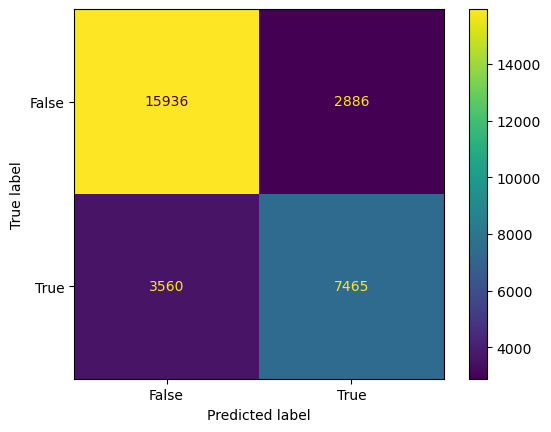

In [30]:
confusion_matrix = metrics.confusion_matrix(target_test, pred_rf_clf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [31]:
print(classification_report(target_test, pred_rf_clf))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83     18822
           1       0.72      0.68      0.70     11025

    accuracy                           0.78     29847
   macro avg       0.77      0.76      0.77     29847
weighted avg       0.78      0.78      0.78     29847



## Random Forest Model with Grid Search

The next model uses GridSearch to find the best parameters for the Random Forest model. This version of the model uses the SMOTE dataset as well. The optimal parameters identified were: 
- criterion: entropy
- max_depth: None
- min_samples_leaf: 3
- min_samples_split: 10
- n_estimators: 100

<b> Results: </b> 

The most important feature in this classifer is still Deposit Type. 

Precision: For class 0, it's 0.81, meaning that when the model predicts a sample belongs to class 0, it is correct 81% of the time. For class 1, it's 0.75, indicating 75% accuracy in predicting class 1 instances. For Class 0 the precision went down by 2 percentage points, and it went up 3 percentage points for Class 1. 

Recall: For class 0, it's 0.88, suggesting that the model correctly identifies 88% of all actual class 0 instances. For class 1, it's 0.66 meaning that the model identifies 66% of all actual class 1 instances. This is a slight improvement for Class 0 but two percentage points lower for Class 1. 

In [32]:
rf_clf_grid = RandomForestClassifier()

In [33]:
rf_param_grid = {
    "n_estimators": [10, 30, 100],
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 2, 6, 10, 18],
    "min_samples_split": [5, 10],
    "min_samples_leaf": [3, 6],
}

In [34]:
### Commenting out Grid Search to save computational time
# rf_grid_search = GridSearchCV(rf_clf_grid, rf_param_grid, cv=3)
# rf_grid_search.fit(data_train_resampled, target_train_resampled)

# print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
# print("")
# print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 76.81%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100}


In [36]:
rf_clf_grid = RandomForestClassifier(criterion= 'entropy', max_depth =None, min_samples_leaf= 3, min_samples_split= 10, n_estimators = 100)

In [37]:
rf_clf_grid.fit(data_train_resampled, target_train_resampled)

RandomForestClassifier(criterion='entropy', min_samples_leaf=3,
                       min_samples_split=10)

In [38]:
rf_grid_pred = rf_clf_grid.predict(data_test)

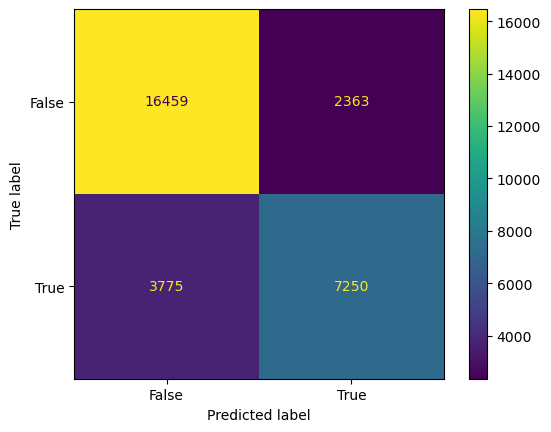

In [39]:
confusion_matrix = metrics.confusion_matrix(target_test, rf_grid_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [40]:
print(classification_report(target_test, rf_grid_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84     18822
           1       0.75      0.66      0.70     11025

    accuracy                           0.79     29847
   macro avg       0.78      0.77      0.77     29847
weighted avg       0.79      0.79      0.79     29847



In [41]:
top_features = get_top_features(rf_clf_grid, data_train)
print("Top 10 Features and Importances:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

Top 10 Features and Importances:
deposit_type_No Deposit: 0.3367009254542392
total_of_special_requests: 0.13266657126290132
previous_cancellations: 0.09937743097019337
booking_changes: 0.0684881315620781
market_segment_Online TA: 0.05059190357440365
market_segment_Groups: 0.043258219022039225
stays_in_weekend_nights: 0.03662834582651134
adults: 0.02936235901389022
hotel_City Hotel: 0.02718715741446497
market_segment_Offline TA/TO: 0.025010832041617404


### Selecting Final Model

The final model section is the Random Forest without applying any of the hyperparameters found in while running Gridsearch. This decsion was taken by focusing on the recall score for Class 1. 

This model has a recall score of 68% which means that it identifies correctly 68% of actual Class 1 instances. This is a 7 percentage point increase from the Baseline model. 

By focusing on the recall score, the evaluation is focused on minimizing false negatives. These would be cases where a reservation was not flagged as at risk for cancelation, but then it was canceled, as these pose a higher risk to the Hotel. The confusion matrix also reveals that the model only missed 12% of cancelations. 

Text(0.5, 1.0, 'Model Performance')

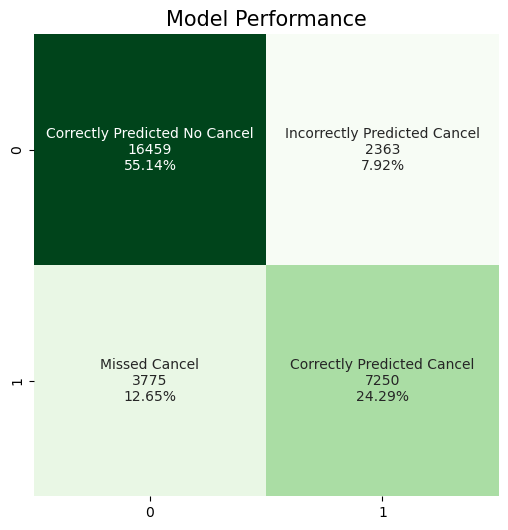

In [42]:
#Create plot
fig, ax=plt.subplots(figsize=(6,6))

#Get predictions and confusion matrix
y_pred = rf_clf_grid.predict(data_test)
cf_matrix = metrics.confusion_matrix(target_test, y_pred)

#Set group names and % of values
group_names = ["Correctly Predicted No Cancel","Incorrectly Predicted Cancel","Missed Cancel","Correctly Predicted Cancel"]
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]                
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
                    
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in  zip(group_names,group_counts,group_percentages)]         
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens',ax=ax,cbar=False)


ax.set_title("Model Performance",fontsize=15)

## Conclusion and Next Steps

The development of this classification model for identifying reservations that are at risk for cancellation is a step towards optimizing operational efficiency and revenue management for Hotels. 

<b> The benefits of deploying this model include: </b> 

- Enabling proactive intervention strategies by flagging reservations deemed at risk of cancellation, allowing hotel management to allocate resources effectively and implement targeted retention efforts. By identifying high-risk bookings in advance, hotels can tailor personalized incentives or communication strategies to mitigate cancellations and preserve revenue streams.

- Providing valuable insights into the underlying drivers of cancellations. The model sheds light on factors such as booking lead time, pricing dynamics, seasonal trends, and customer demographics. 

<b> Next Steps: </b> 
- Continual monitoring and evaluation of model performance will be crucial to ensure its effectiveness and reliability over time.
- Regular updates and iterations based on real-time data insights will ensure that the model remains agile and responsive to changing business environments.
- Cllaboration with cross-functional teams, including revenue management, marketing, and customer service, will facilitate the integration of the classification model into broader business strategies and decision-making processes.